# Image preprocessing in TensorFlow Tutorials for CIFAR-10

Google's TensorFlow Tutorials explains how to build [Convolutional Neural Networks](https://www.tensorflow.org/versions/r0.8/tutorials/deep_cnn/index.html#convolutional-neural-networks) for the "CIFAR-10" image classification problem.

In the [model inputs](https://www.tensorflow.org/versions/r0.8/tutorials/deep_cnn/index.html#model-inputs) part, it explains about the image preprocessing of the training data to have more generalized images from given dataset.

I will show some examples of the preprocessed images here.

## Preparation

First, download the dataset from the CIFAR-10 web site.

In [ ]:
%%bash
mkdir -p /tmp/cifar10_data
cd /tmp/cifar10_data
curl -OL http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
tar xzf cifar-10-binary.tar.gz

You have the following data binaries. I'll use 'test_batch.bin' in the following examples.

In [1]:
!ls -lR /tmp/cifar10_data

/tmp/cifar10_data:
total 21044
drwxr-xr-x. 2 2156 1103     4096 Jun  4  2009 cifar-10-batches-bin
-rw-r--r--. 1 root root 21544960 May  4 00:54 cifar-10-binary.tar.gz

/tmp/cifar10_data/cifar-10-batches-bin:
total 180080
-rw-r--r--. 1 2156 1103       61 Jun  4  2009 batches.meta.txt
-rw-r--r--. 1 2156 1103 30730000 Jun  4  2009 data_batch_1.bin
-rw-r--r--. 1 2156 1103 30730000 Jun  4  2009 data_batch_2.bin
-rw-r--r--. 1 2156 1103 30730000 Jun  4  2009 data_batch_3.bin
-rw-r--r--. 1 2156 1103 30730000 Jun  4  2009 data_batch_4.bin
-rw-r--r--. 1 2156 1103 30730000 Jun  4  2009 data_batch_5.bin
-rw-r--r--. 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r--. 1 2156 1103 30730000 Jun  4  2009 test_batch.bin


Import some modules.

In [2]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

This is the function to read (image, label) pairs from the data binary.

In [3]:
def read_cifar10(filename_queue):
    class CIFAR10Record(object):
        pass
    result = CIFAR10Record()

    label_bytes = 1
    result.height = 32
    result.width = 32
    result.depth = 3
    image_bytes = result.height * result.width * result.depth
    record_bytes = label_bytes + image_bytes
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    result.key, value = reader.read(filename_queue)
    record_bytes = tf.decode_raw(value, tf.uint8)
    result.label = tf.cast(
        tf.slice(record_bytes, [0], [label_bytes]), tf.int32)
    depth_major = tf.reshape(tf.slice(record_bytes, [label_bytes], [image_bytes]),
                           [result.depth, result.height, result.width])
    # Convert from [depth, height, width] to [height, width, depth].
    result.uint8image = tf.transpose(depth_major, [1, 2, 0])

    return result

## Original images

This is a code to show some samples of the original images. It picks up 8 samples for each label.

They are RGB 32x32 pixel images across 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

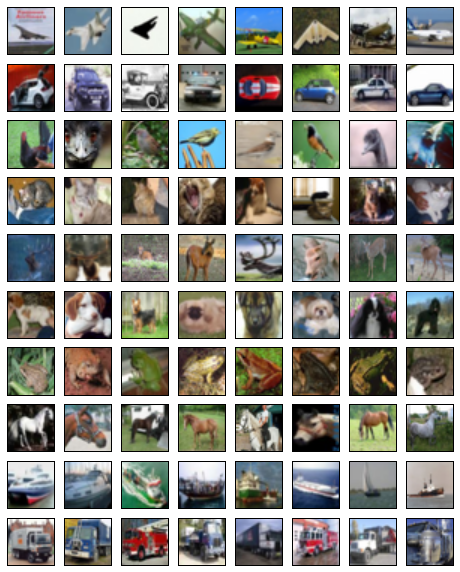

In [4]:
sess = tf.InteractiveSession()
filename = '/tmp/cifar10_data/cifar-10-batches-bin/test_batch.bin'
q = tf.FIFOQueue(99, [tf.string], shapes=())
q.enqueue([filename]).run(session=sess)
q.close().run(session=sess)
result = read_cifar10(q)

samples = [[] for l in range(10)]
while(True):
    label, image = sess.run([result.label, result.uint8image])
    label = label[0]
    if len(samples[label]) < 8:
        samples[label].append(image)
    if all([len(samples[l]) >= 8 for l in range(10)]):
        break
        
fig = plt.figure(figsize=(8,10))
for l in range(10):
    for c in range(8):
        subplot = fig.add_subplot(10, 8, l*8+c+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        image = samples[l][c]
        subplot.imshow(image.astype(np.uint8))
        
sess.close()

## Preprocessed images

It doesn't use the original images during *either* evaluation (actual classification) or training (model building).

For evaluation, it crops the image (trims down fringes) to focus on the object in the center.

For training, it generates multiple images from a single image with the following operations.

- Crops the image at random points (instead of the center).
- Randomly flip the image from left to right.
- Randomly distort the image brightness.
- Randomly distort the image contrast.

In addition, it applies the "whitening" operation for all images which normalizes the color dynamic range.

This is a function to apply these operations.

In [5]:
def distorted_samples(image):

    reshaped_image = tf.cast(image, tf.float32)
    width, height = 24, 24
    float_images = []

    resized_image = tf.image.resize_image_with_crop_or_pad(reshaped_image,
                                                           width, height)
    float_image = tf.image.per_image_whitening(resized_image)
    float_images.append(float_image)

    for i in range(8):
        distorted_image = tf.random_crop(reshaped_image, [height, width, 3])
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        distorted_image = tf.image.random_brightness(distorted_image,
                                                        max_delta=63)
        distorted_image = tf.image.random_contrast(distorted_image,
                                                         lower=0.2, upper=1.8)
        float_image = tf.image.per_image_whitening(distorted_image)
        float_images.append(float_image)
    float_images = tf.concat(0,float_images)
    
    return float_images

This is a code to show samples of:

- Original image in the first column.
- Evaluation image in the second column.
- Training images in other columns.

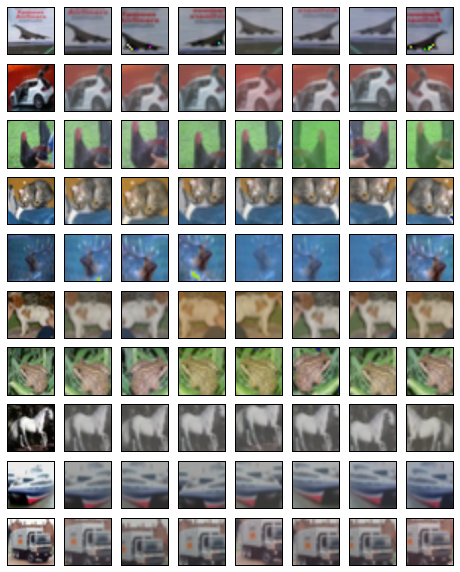

In [6]:
sess = tf.InteractiveSession()
filename = '/tmp/cifar10_data/cifar-10-batches-bin/test_batch.bin'
q = tf.FIFOQueue(99, [tf.string], shapes=())
q.enqueue([filename]).run(session=sess)
q.close().run(session=sess)
result = read_cifar10(q)

fig = plt.figure(figsize=(8,10))
c = 0
original = {}
modified = {}

while len(original.keys()) < 10:
    label, orig, dists = sess.run([result.label, result.uint8image, distorted_samples(result.uint8image)])
    label = label[0]
    if not label in original.keys():
        original[label] = orig
        modified[label] = dists

for l in range(10):
    orig, dists = original[l], modified[l]
    c += 1
    subplot = fig.add_subplot(10, 8, c)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(orig.astype(np.uint8))

    for i in range(7):
        c += 1
        subplot = fig.add_subplot(10, 8, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        pos = i*24
        image = dists[pos:pos+24]*40+120
        subplot.imshow(image.astype(np.uint8))
        
sess.close()